# DAY56

- 作者：疏锦行
- 微信：shujinxing777

在介绍时间序列模型前，你需要知道时间数据对应的检验流程。把今天的内容吸收会帮助你理解时间序列预测任务，从来龙去脉中感受为什么需要这些流程。


同样，今日的内容只要知道逻辑即可，用到的时候让ai来写代码即可，不要把自己活成记忆机器。

# 一、假设检验

## 1.1 原假设和备择假设

由于序列预测本身对数据有很多要求，所以在此之前我们需要进行一定的检验来看后续选择什么样的操作。

如果你想用科学的方法证明一件事，你不能直接去证明它‘是’，而是要先假设它‘不是’，然后用证据去推翻这个‘不是’的假设。这在统计学里，就叫做假设检验。因为证明是很困难，需要证明很多个条件，但是证明不是只是一条不满足必须的条件就可以了。所以顺着这个思路，一般首先默认的假设都是要求多的那个情况。

比如，在法庭上，任何嫌疑人在被定罪前，都首先被假设为无罪的 (Innocent)。这个“无罪”的默认状态，就是我们要挑战的原假设 (H₀)。他的要求比较多，不能犯各种罪。想推翻这个假设，找到一条罪状就行。
更进一步而言，原假设需要是一个清晰、单一的状态，用数学语言来写 罪=0，如果H0是犯人有罪，那么定义就不清晰，比如罪=1 罪=2均可。


而我们作为“检察官”，希望证明的是与之相反的备择假设 (H₁) —— 即“嫌疑人有罪”。这通常是我们期待的、有价值的发现。-----我们想要证明的，是原假设的对立面。



## 1.2 P值与统计量

我们收集数据，选取一个合适的假设检验方法。一般而言，每个检验方法都会有一个对应的统计量，这个统计量反映的是样本数据 偏离“原假设”（如嫌疑人无辜）的程度。统计量的值越大，说明两组数据的差异越明显，越不像巧合。

随之而来的，还有证明这个统计量是否有价值的关键指标——p值 (p-value)。

p值就是“证据强度”的量化指标。它回答了这样一个核心问题：

“如果原假设是真的（即嫌疑人真的是无辜的），我们现在看到的这些证据，有多大的可能性会纯属巧合地发生？” p值越小，说明证据越是与“无辜假设（原假设）”格格不入。

eg：当检察官证明了“如果嫌疑人是无辜的，发生这种事的概率只有十亿分之一（p值极小）”，陪审团和法官会怎么想？他们会想：“看来他很可能不是无辜的，也就是说，他很可能是有罪的 (H₁)！”


我们需要一个“定罪标准”，在统计学中，这个标准通常是 0.05 (即5%)，也叫显著性水平 (Significance Level)。

- 当 p-value < 0.05 (原假设对立面的事件发生概率小)，拒绝原假设
- 当 p-value ≥ 0.05 (原假设对立面的时间发生概率大)，接受原假设



此外，你可能还看到过一个指标，置信区间，它的含义如下：
- 落在置信区间内 = 我们观测到的现象很可能是在 原假设为真的情况下，纯属巧合发生的= 接受原假设
- 落在置信区间外 = 备择假设证据确凿，不是巧合


也就是从统计量-p值-显著性-置信区间 这一条假设检验范式。

记忆口诀：p越小，落在置信区间外，越拒绝原假设。

# 一、白噪声

首先，我们思考一下我们一直追求的目标都是什么？都是训练一个能够学习到规律的模型。

之前的结构化预测（样本独立无关）的机器学习模型，他在预测的时候，如果数据本身就没价值，比如特征和样本毫无关系，你生成一些随机数作为特征，再随机一些数成标签，一样可以训练，但是模型注定也学不到什么东西。

所以需要明白，对数据本身就有要求，比如我最开始绘制下热力图发现特征和标签没啥关系，这个时候就不太正常。






## 1.1 白噪声的定义

在时序预测中，这种要求会更加苛刻，你设想一下，你可以制造一个随机的序列，然后让模型来学习，这注定也是不可能实现的。也就是说 数据本身要具备可预测性。一个完全随机的序列（学术上称为“白噪声”）是不可预测的。它的未来值与过去值没有任何相关性。任何模型试图从中学习规律，最终都只会是徒劳。

什么叫做白噪声呢？他需要满足以下条件：
1. 均值为0
2. 方差恒定
3. 自相关性为0（即过去的值对未来的值没有影响）

我们来生成一组随机序列

生成的前10个数据点:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]


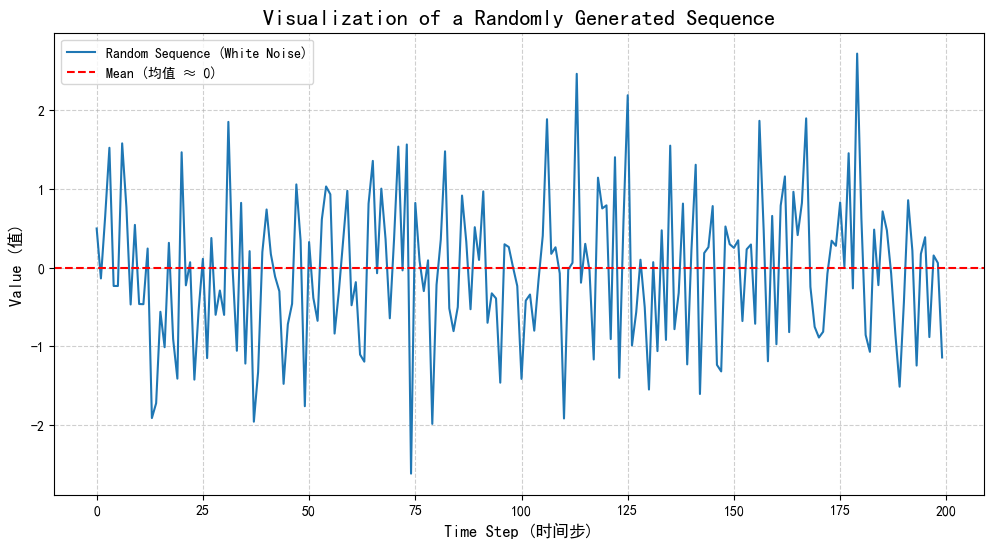

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# 中文显示设置
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示为方块的问题

# --- 1. 生成随机序列数据 ---

# 为了让每次运行的结果都一样，设置一个随机种子（可选）
np.random.seed(42)

# 定义序列的长度
num_points = 200

# 生成一个包含 200 个点的随机序列
# np.random.randn() 从标准正态分布（均值为0，方差为1）中抽取随机样本
random_sequence = np.random.randn(num_points)

print("生成的前10个数据点:")
print(random_sequence[:10])


# --- 2. 可视化序列 ---

# 设置图形大小
plt.figure(figsize=(12, 6))

# 绘制线图
plt.plot(random_sequence, label='Random Sequence (White Noise)')

# 添加标题和标签
plt.title('Visualization of a Randomly Generated Sequence', fontsize=16)
plt.xlabel('Time Step (时间步)', fontsize=12)
plt.ylabel('Value (值)', fontsize=12)

# 添加一条水平线，表示序列的均值（接近于0）
plt.axhline(y=0, color='r', linestyle='--', label='Mean (均值 ≈ 0)')

# 显示网格和图例
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# 显示图形
plt.show()


其中plt.plot() 的核心功能就是直线，把每2个点用直线连起来，构成了这个时序图。

## 1.2 ACF检验
为了检验这组随机数是否是白噪声，我们来进行如下操作

其中，acf假设的是在滞后 k 阶上，序列的自相关系数为 0 (ρₖ = 0)

--- 开始检验白噪声属性 ---
1. 序列的均值: -0.0408
   (结论: 均值非常接近0，满足条件。)

2. 序列的方差: 0.8624
   (结论: 方差接近于1，满足条件。np.random.randn理论方差为1)

3. 检验自相关性 (使用ACF图):
   - ACF图展示了序列与它过去值之间的相关性。
   - 对于白噪声，只有lag=0时相关性为1，其他所有lag的相关性都应在蓝色置信区间内（统计上不显著）。


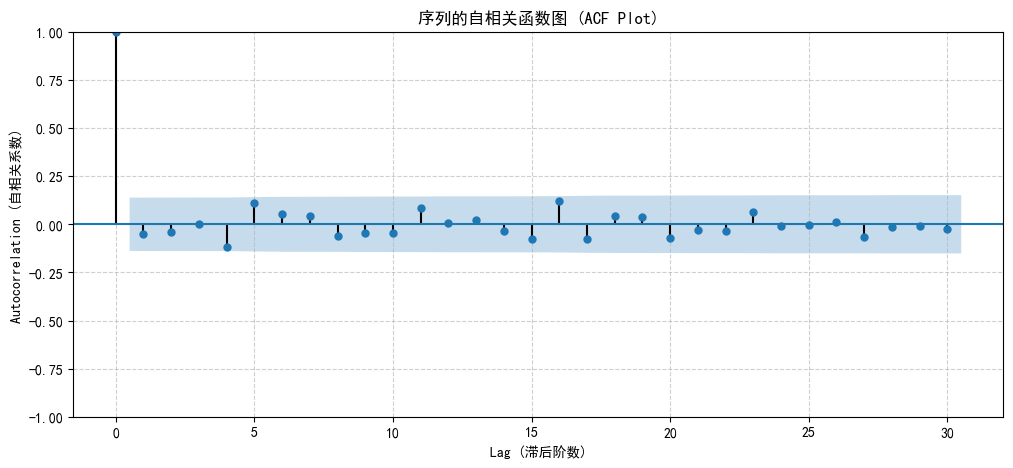

In [2]:
from statsmodels.graphics.tsaplots import plot_acf 
print("--- 开始检验白噪声属性 ---")

# 检验 1: 均值是否接近 0
mean = np.mean(random_sequence)
print(f"1. 序列的均值: {mean:.4f}")
if -0.1 < mean < 0.1:
    print("   (结论: 均值非常接近0，满足条件。)\n")
else:
    print("   (结论: 均值偏离0较远。)\n")

# 检验 2: 方差是否恒定（且接近理论值1）
# 对于我们生成的数据，方差恒定是与生俱来的。我们主要检查其值。
variance = np.var(random_sequence)
print(f"2. 序列的方差: {variance:.4f}")
if 0.8 < variance < 1.2:
    print("   (结论: 方差接近于1，满足条件。np.random.randn理论方差为1)\n")
else:
    print("   (结论: 方差偏离1较远。)\n")


# 检验 3: 自相关性是否为 0
# 这是最核心的检验。我们通过绘制ACF图来完成。
print("3. 检验自相关性 (使用ACF图):")
print("   - ACF图展示了序列与它过去值之间的相关性。")
print("   - 对于白噪声，只有lag=0时相关性为1，其他所有lag的相关性都应在蓝色置信区间内（统计上不显著）。")

# 创建一个新的图形来绘制ACF图
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(random_sequence, lags=30, ax=ax) # 我们查看前30个滞后的相关性
ax.set_title('序列的自相关函数图 (ACF Plot)')
ax.set_xlabel('Lag (滞后阶数)')
ax.set_ylabel('Autocorrelation (自相关系数)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

我们介绍下这个ACF图如何看，他是用来检验自相关性的

- 纵轴是自相关系数，表示相关性强弱。
- 横轴是滞后阶数（Lag）。Lag=k 代表序列在 t 时刻的值与 t-k 时刻的值之间的相关性。
- 蓝色的区域是95%置信区间。可以理解为一个“无关紧要”的区域。如果相关系数的柱子落在这个区域内，我们就认为它的相关性从统计学上看不显著，可以当作是0。

观察我们的图：
- 在 Lag=0 的地方，柱子顶到了1。这很正常，因为任何数据和它自己都是100%相关的。
- 在所有其他的滞后阶数（Lag > 0），所有的柱子都完全落在了蓝色区域内部。落在置信区域=无关紧要

这也说明，ACF图清晰地显示，除了自身相关外，该序列的过去值对当前值没有任何显著的线性相关性。

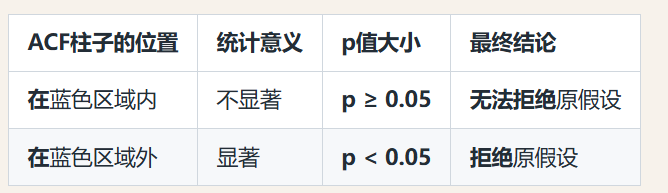

## 1.3 PACF检验

实际上，除了acf检验，还存在pacf检验，他是假设：k 阶偏自相关系数为 0，这句话的意思是控制了中间所有滞后项（y (t-1), y (t-2), ..., y (t-k+1)）的影响后，y (t) 与 y (t-k) 之间无直接线性关联

- ACF (自相关)：衡量 y(t) 和 y(t-k) 之间的总体相关性，包含了所有中间时刻（t-1, t-2, …）的间接影响。
- PACF (偏自相关)：衡量 y(t) 和 y(t-k) 之间的直接相关性，剔除了所有中间时刻的干扰。

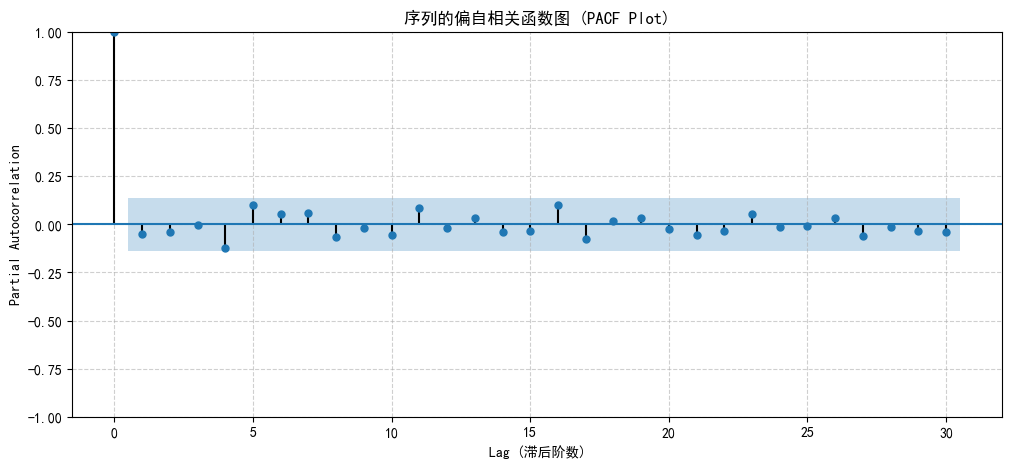

In [3]:
from statsmodels.graphics.tsaplots import plot_pacf # 引入PACF图
# --- 绘制PACF图 ---
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(random_sequence, lags=30, ax=ax)
ax.set_title('序列的偏自相关函数图 (PACF Plot)')
ax.set_xlabel('Lag (滞后阶数)')
ax.set_ylabel('Partial Autocorrelation')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

几乎和ACF图一模一样，所有滞后项都落在蓝色置信区间内。

## 1.4 Ljung-Box检验

- ACF 图：像是在看一支足球队里每个球员（每个滞后项）的表现。你可能会看到某个球员（某个lag）稍微跑出了边界（置信区间），但这可能只是偶然。

- Ljung-Box 检验：像是球队教练做的赛后总结。它不只看单个球员，而是综合评估整个球队（比如前10个或前20个滞后项）的整体表现，然后给出一个明确的结论：“我们这支队伍（这个序列）整体上有没有形成有效的配合（自相关性）？

Ljung-Box 检验也属于自相关性检验，但是更加专业。


汇总下之前的检验

1. 序列的均值: -0.0408
2. 序列的方差: 0.8624

3. 检验自相关性 (使用ACF图)...


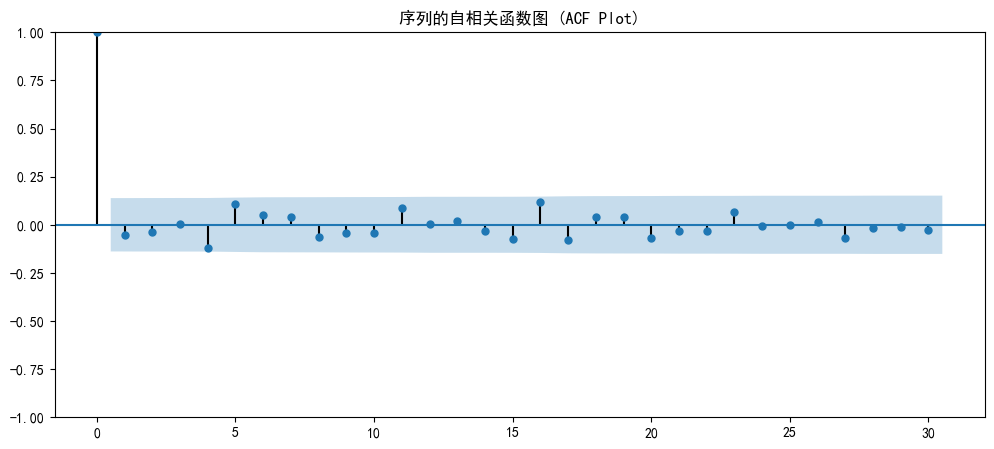


4. 进行严格的白噪声检验 (Ljung-Box Test)
   - 原假设(H₀): 序列是白噪声。
   - 判断标准: 如果 p-value > 0.05，则接受原假设，认为序列是白噪声。

Ljung-Box检验结果:
      lb_stat  lb_pvalue
10   8.849179   0.546474
20  18.264036   0.570020
30  21.000649   0.887868

--- 检验结论 ---
在滞后30阶时，p-value (0.8879) 大于 0.05。
结论：我们无法拒绝原假设，该序列是白噪声。


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
# 引入Ljung-Box检验的函数
from statsmodels.stats.diagnostic import acorr_ljungbox 

# --- 您的原始代码部分 ---
np.random.seed(42)
num_points = 200
random_sequence = np.random.randn(num_points)

# --- 白噪声属性检验---
mean = np.mean(random_sequence)
variance = np.var(random_sequence)
print(f"1. 序列的均值: {mean:.4f}")
print(f"2. 序列的方差: {variance:.4f}\n")
print("3. 检验自相关性 (使用ACF图)...")
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(random_sequence, lags=30, ax=ax)
ax.set_title('序列的自相关函数图 (ACF Plot)')
plt.show()

# --- 新增：使用 Ljung-Box 检验进行严格的白噪声检验 ---
print("\n" + "="*50)
print("4. 进行严格的白噪声检验 (Ljung-Box Test)")
print("="*50)
print("   - 原假设(H₀): 序列是白噪声。")
print("   - 判断标准: 如果 p-value > 0.05，则接受原假设，认为序列是白噪声。")

# 执行Ljung-Box检验
# 我们通常会检查一系列的滞后项，比如前10、20、30个
# 函数返回一个包含统计量和p值的DataFrame
ljung_box_result = acorr_ljungbox(random_sequence, lags=[10, 20, 30], return_df=True)

print("\nLjung-Box检验结果:")
print(ljung_box_result)

# --- 结论解释 ---
print("\n--- 检验结论 ---")
# 我们可以检查最后一个（最严格的）p值
# .iloc[-1] 获取最后一行, .loc['lb_pvalue'] 获取p值
last_p_value = ljung_box_result.iloc[-1]['lb_pvalue']

if last_p_value < 0.05:
    print(f"在滞后30阶时，p-value ({last_p_value:.4f}) 小于 0.05。")
    print("结论：我们拒绝原假设，该序列不是白噪声。")
else:
    print(f"在滞后30阶时，p-value ({last_p_value:.4f}) 大于 0.05。")
    print("结论：我们无法拒绝原假设，该序列是白噪声。")



- 第一列 lb_stat 是Ljung-Box统计量的值。
- 第二列 lb_pvalue 是我们最关心的p值。
- 行索引 10, 20, 30 代表我们综合考虑了前10个、前20个、前30个滞后项的自相关性。

所有的p值都远远大于0.05，代表接受原假设。p值是结论，统计量是证据，统计量的值越大，证据就越强。

# 二、平稳性

我们刚刚通过严格的检验，确认了什么是白噪声——一种完全随机、不包含任何可预测规律的序列。那么，一个至关重要的问题就浮现了：如果一个时间序列 不是 白噪声，那它是什么样的？

一个序列之所以不是白噪声，正是因为它违反了白噪声的三大铁律之一或多个。

先看相关性，这是最关键的一点。一个序列的价值在于它的过去能在一定程度上预示它的未来。这种“前后关联”的特性，就是自相关性。通过ACF图可以捕捉这种关系。


## 2.1 平稳性的定义

然后我们来看均值和方差，他们不为0，意味着他们可以变化也可以不变化。所以我们要引入平稳性（Stationarity）和非平稳性来进一步细分这个模式。


一个平稳的序列，其统计特性（如均值、方差variance）不会随时间变化而变化。这使得序列中的规律是可重复、可学习的。

非平稳的例子：一个持续上涨的股票价格（均值在变），一个夏天销量高、冬天销量低的冰淇淋销售数据（存在季节性，均值也在周期性变化）。


所以，在寻找规律前，我们首先要问：这个规律本身稳定吗？如果一个序列的均值和波动性总在变，那我们今天学到的规律，明天可能就失效了。因此，检验序列的平稳性，是时序分析中至关重要的一步。它是很多经典模型（如ARIMA）能够有效工作的前提。

## 2.2 ADF检验（单位根检验）

ADF检验是一个假设检验，ADF检验的唯一目的就是判断一个时间序列是否平稳（Stationary），一个序列如果其统计特性（如均值、方差）不随时间推移而变化，就是平稳的。白噪声看起来乱，但是实际上他确是平稳的。




你只需要记住它的两个假设和判断规则：

- 原假设 (H₀): 序列是非平稳的（存在单位根）。
- 备择假设 (H₁): 序列是平稳的。
- 判断规则: 我们主要看输出的 p-value。
  - 如果 p-value < 0.05：我们有充分的理由拒绝原假设，采纳备择假设，即认为序列是平稳的。
  - 如果 p-value ≥ 0.05：我们无法拒绝原假设，即认为序列是非平稳的。

In [5]:
# 引入ADF检验的函数
from statsmodels.tsa.stattools import adfuller 


# --- 新增：使用ADF检验来判断平稳性 ---

print("开始进行ADF平稳性检验...")

# 执行ADF检验
# adfuller()函数会返回一个包含多个结果的元组
adf_result = adfuller(random_sequence)

# 提取并展示主要结果
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

print(f"ADF统计量 (ADF Statistic): {adf_statistic:.4f}")
print(f"p值 (p-value): {p_value:.4f}")
print("临界值 (Critical Values):")
for key, value in critical_values.items():
    print(f'    {key}: {value:.4f}')

print("\n--- 检验结论 ---")
# 根据p值进行判断
if p_value < 0.05:
    print(f"p-value ({p_value:.4f}) 小于 0.05，我们强烈拒绝原假设(H₀)。")
    print("结论：该序列是平稳的 (Stationary)。")
else:
    print(f"p-value ({p_value:.4f}) 大于或等于 0.05，我们无法拒绝原假设(H₀)。")
    print("结论：该序列是非平稳的 (Non-stationary)。")

# 也可以通过比较ADF统计量和临界值来判断，结论是一致的
if adf_statistic < critical_values['5%']:
    print("\n补充判断：ADF统计量小于5%的临界值，同样表明序列是平稳的。")



开始进行ADF平稳性检验...
ADF统计量 (ADF Statistic): -14.7442
p值 (p-value): 0.0000
临界值 (Critical Values):
    1%: -3.4636
    5%: -2.8762
    10%: -2.5746

--- 检验结论 ---
p-value (0.0000) 小于 0.05，我们强烈拒绝原假设(H₀)。
结论：该序列是平稳的 (Stationary)。

补充判断：ADF统计量小于5%的临界值，同样表明序列是平稳的。


# 三、 季节性

季节性（Seasonality） 是指时间序列中以固定的、已知的频率重复出现的模式或周期性波动。


把它想象成数据的“心跳”或“呼吸”。它是有规律、可预测的。举例：

- 冰淇淋销量：每年夏天达到高峰，冬天降到谷底。这个模式以12个月为周期重复。
- 工作日用电量：每天早上8点开始攀升，中午稍降，下午达到另一个高峰，晚上回落。这个模式以24小时为周期重复。
- 零售业销售额：每年第四季度（受节假日影响）最高。这个模式以4个季度为周期重复。


关键点：频率是固定的和已知的（年、季度、月、周、日）。这与“周期性”（Cyclical）不同，后者的模式长度可变且不固定，比如商业周期。


季节性是数据中最强大、最明显的预测信号之一。如果一个模型不能识别和利用季节性，它的预测结果将会出现系统性的、周期性的巨大误差。
例如，一个不考虑季节性的模型在预测12月份的零售额时，可能会基于11月份的数据给出一个平稳的预测，完全错过圣诞节带来的销售高峰。

如果一个序列存在季节性，它的ACF图会呈现出非常独特的形态：在代表季节性周期的滞后点上出现显著的尖峰。对于月度数据（年度季节性，周期为12），在 lag=12, 24, 36, ... 的位置看到很高的相关性柱子。因为今年1月的数据和去年1月的数据高度相关，和前年1月的也相关。

--- 方法一：肉眼观察 ---


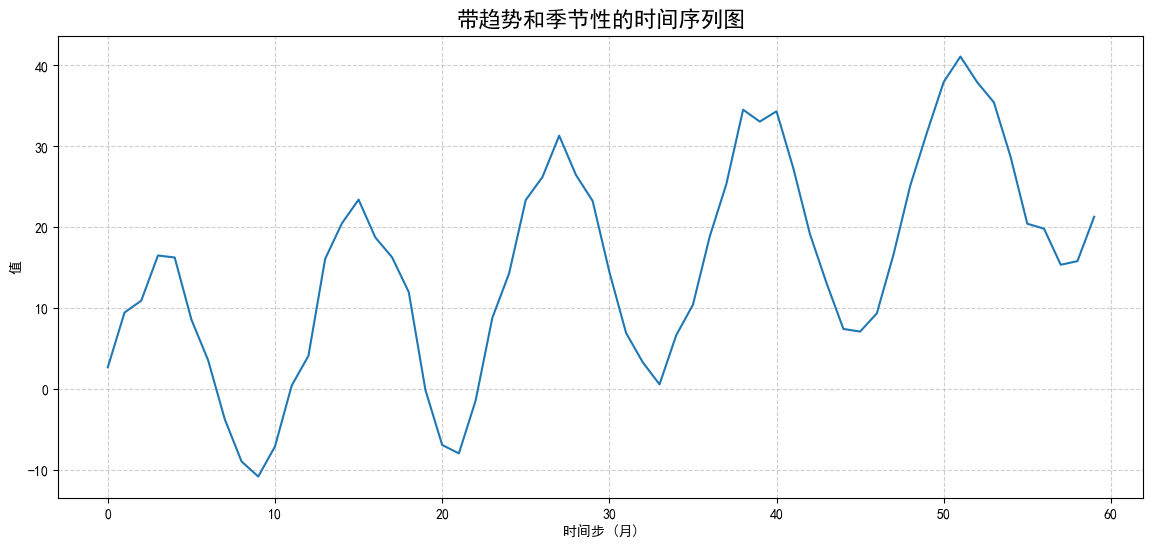

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
# 显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False

# --- 1. 创建一个带季节性的序列 ---
# 我们模拟一个为期5年的月度数据（60个点）
num_points = 60
time = np.arange(num_points)

# a. 创建一个线性趋势
trend = 0.5 * time

# b. 创建一个季节性成分（周期为12个月）
# 使用sin函数来模拟年度周期性波动
seasonal_component = 15 * np.sin(2 * np.pi * time / 12)

# c. 创建一些随机噪声
np.random.seed(10)
noise = np.random.randn(num_points) * 2

# d. 合成最终序列
seasonal_data = trend + seasonal_component + noise


# --- 2. 开始检验季节性 ---

# 方法一：肉眼观察
print("--- 方法一：肉眼观察 ---")
plt.figure(figsize=(14, 6))
plt.plot(seasonal_data)
plt.title('带趋势和季节性的时间序列图', fontsize=16)
plt.xlabel('时间步 (月)')
plt.ylabel('值')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
# 观察：我们可以清晰地看到一个整体上升的趋势，以及每年重复的波峰和波谷。



通过肉眼能清晰地看到数据像波浪一样，一边整体向上（趋势），一边规律地起伏（季节性）。


--- 方法二：ACF图 ---


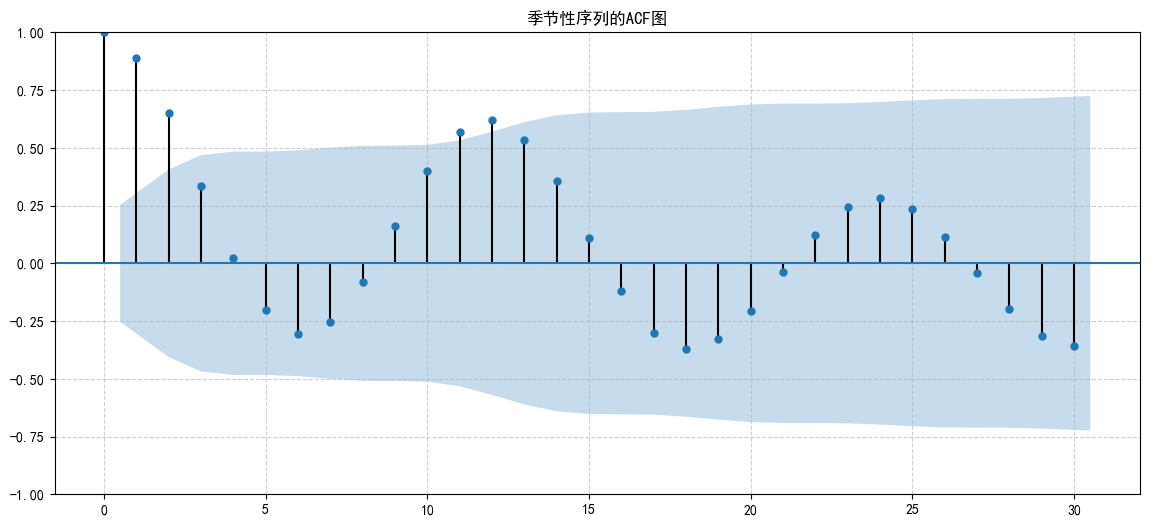

In [7]:
# 方法二：ACF图
print("\n--- 方法二：ACF图 ---")
fig, ax = plt.subplots(figsize=(14, 6))
plot_acf(seasonal_data, lags=30, ax=ax)
ax.set_title('季节性序列的ACF图')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
# 观察：ACF图不仅整体缓慢下降（表明有趋势），更重要的是在lag=12和24的位置出现了明显的峰值！

在 lag=12 和 lag=24 的地方，出现了两个非常突出的“尖峰”，这就像是季节性在ACF图上留下的“指纹”，明确告诉我们存在一个周期为12的规律。


--- 方法三：序列分解 ---


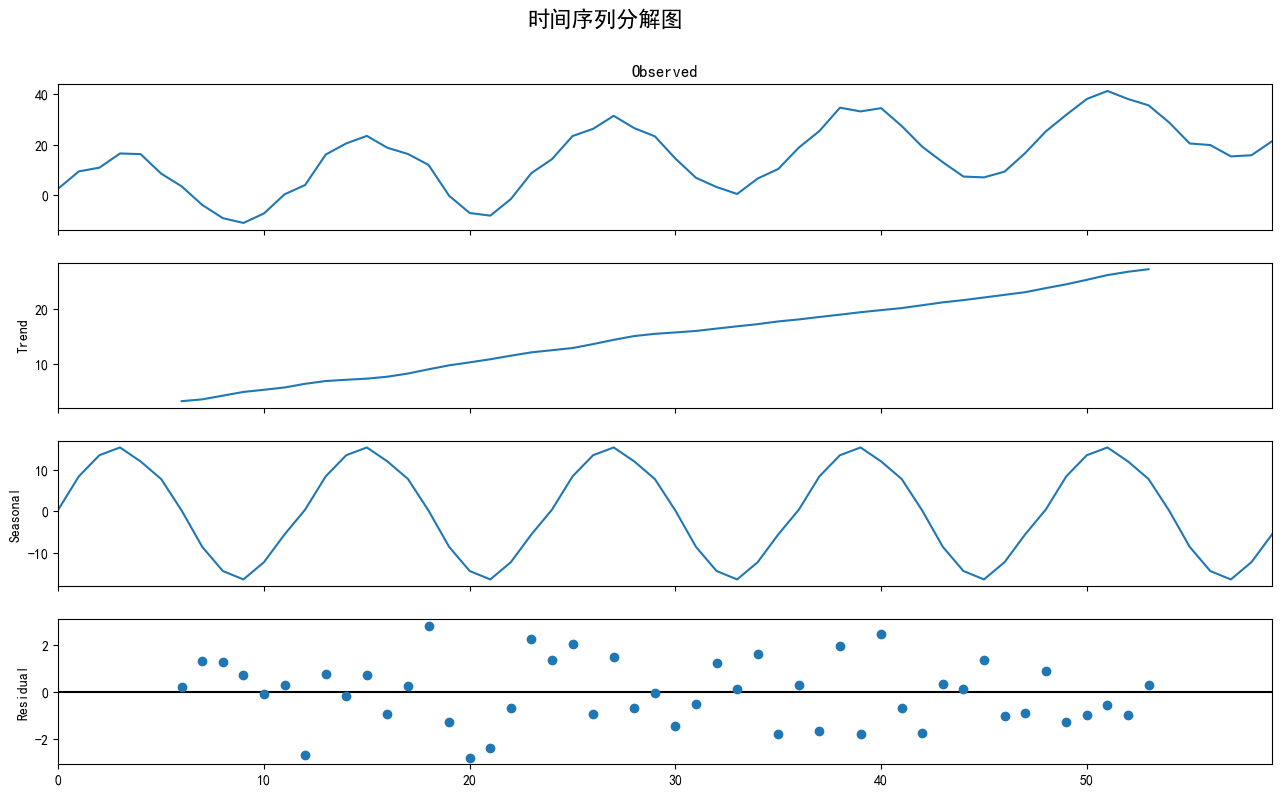

In [8]:
# 方法三：序列分解
print("\n--- 方法三：序列分解 ---")
# 使用statsmodels进行分解（假设为加法模型）
decomposition = seasonal_decompose(seasonal_data, model='additive', period=12)

# 绘制分解图
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.suptitle('时间序列分解图', y=1.02, fontsize=16)
plt.show()
# 观察：分解图清晰地将数据拆分成了趋势、季节性和残差。季节性部分呈现完美的年度周期，而残差看起来像随机噪声。

序列分解图：
1. Trend图：捕捉到了数据长期、平滑的上升趋势。
2. Seasonal图：完美地提取出了那个每年重复的、固定的波动模式。
3. Resid图：剩下的残差部分，看起来杂乱无章，非常接近白噪声。

其中，这个残差是非线性的部分，并不一定是白噪声，这意味着残差的规律有可能是可以被学习的。传统的时序模型无法处理非线性的部分，但是可以学习趋势和季节性。这才是后续一切工作的由来。

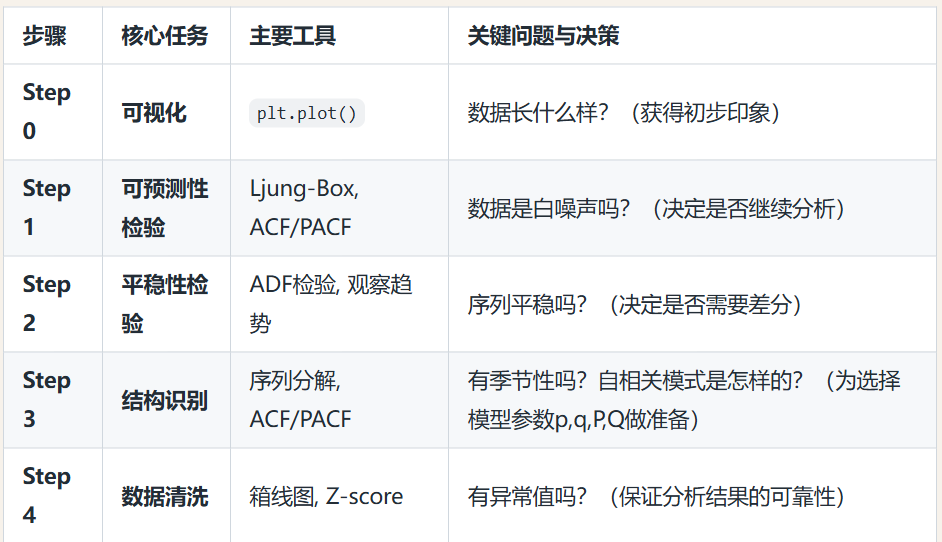